In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

from PIL import Image, ImageDraw, ImageFont
from glob import glob
import seaborn as sns
import os
import json
from torch.utils.data import DataLoader, Subset
import torch
import albumentations as A
import tqdm
import torch.nn.functional as F
import torch.nn as nn

In [36]:
IMAGE_ROOT = "/data/ephemeral/home/data/train/DCM"
LABEL_ROOT = "/data/ephemeral/home/data/train/outputs_json"

CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]
CLASSES_grouped = [
    ['finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19'],
    ['Trapezium', 'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform'], 
    ['Radius', 'Ulna']
]

In [12]:
# 시각화를 위한 팔레트를 설정합니다.
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# 시각화 함수입니다. 클래스가 2개 이상인 픽셀을 고려하지는 않습니다.
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

In [13]:
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}
jsons = [os.path.join(LABEL_ROOT, data) for data in jsons]

pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

values = np.array([0]*29)
for path in jsons:
    with open(path, "r") as f:
        temp = json.load(f)
        for i in range(len(temp["annotations"])):
            points = np.array(temp["annotations"][i]["points"])
            values[i] += PolyArea(points[:, 0], points[:, 1]) 

values = values/np.sum(values)

## 각 클래스 별 Polygon 넓이 확인하기

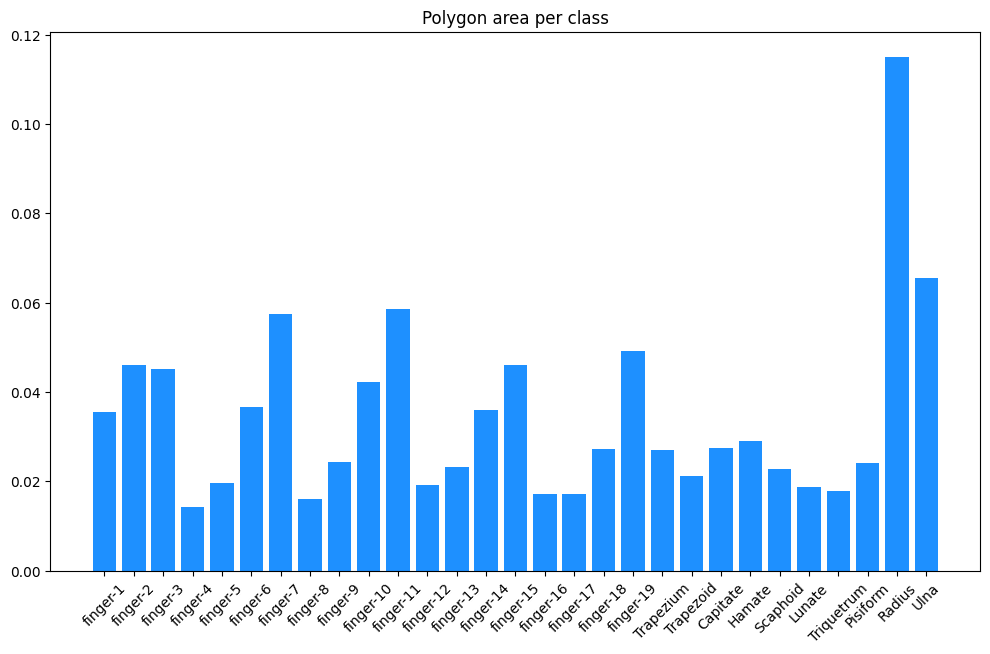

In [14]:
fig, ax = plt.subplots(figsize=(12, 7))
plt.title("Polygon area per class")
plt.bar([CLASSES[i] for i in range(29)], values, color="dodgerblue")
plt.xticks(rotation=45)
plt.show()

## 시각화 하기

In [41]:
COLOR = {
    'finger': (120,203,228),
    'Trapezoid': (145,42,177),
    'Pisiform': (145,42,177),
    'Radius': (210,71,77),
    'Ulna': (210,71,77),
    'wrist': (193,223,159)
}

In [82]:
def random_vis_with_plt(method: str):
    base_path = '/data/ephemeral/home/data'
    img_root = os.path.join(base_path, method, 'DCM')
    annot_root = os.path.join(base_path, method, 'outputs_json')
    
    print(f"Image root path: {img_root}")
    print(f"Annotation root path: {annot_root}")
    
    # 디렉토리만 선택하도록 수정
    patient_dirs = [d for d in glob(os.path.join(img_root, "*")) if os.path.isdir(d)]
    print(f"Found {len(patient_dirs)} patient directories")
    
    if not patient_dirs:
        raise ValueError(f"No patient directories found in {img_root}")
    
    # 환자 디렉토리 중 하나를 랜덤 선택
    patient_dir = random.choice(patient_dirs)
    folder_name = os.path.basename(patient_dir)
    
    print(f"Selected patient directory: {patient_dir}")
    print(f"Folder name: {folder_name}")
    
    # 이미지 파일 찾기
    img_paths = glob(os.path.join(patient_dir, "*.png"))
    if not img_paths:
        img_paths = glob(os.path.join(patient_dir, "*.jpg")) or \
                   glob(os.path.join(patient_dir, "*.jpeg")) or \
                   glob(os.path.join(patient_dir, "*.dcm"))
    
    print(f"Found image paths: {img_paths}")
    
    # annotation 파일 찾기
    annot_paths = glob(os.path.join(annot_root, folder_name, "*.json"))
    print(f"Found annotation paths: {annot_paths}")
    
    if not img_paths or len(img_paths) < 2:
        raise ValueError(f"Expected 2 images, found {len(img_paths)} in {patient_dir}")
    
    if not annot_paths or len(annot_paths) < 2:
        raise ValueError(f"Expected 2 annotations, found {len(annot_paths)} in {annot_root}/{folder_name}")
    
    l_img_path, r_img_path = sorted(img_paths)[:2]
    l_annot_path, r_annot_path = sorted(annot_paths)[:2]
    
    l_img = Image.open(l_img_path).convert("RGB")
    r_img = Image.open(r_img_path).convert("RGB")
    l_json = json.load(open(l_annot_path))
    r_json = json.load(open(r_annot_path))
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 15))
    
    # 왼쪽 이미지 시각화
    axes[0].imshow(l_img)
    axes[0].set_title(os.path.basename(l_img_path))
    axes[0].axis('off')
    for annot in l_json['annotations']:
        points = [tuple(pts) for pts in annot['points']]
        orin_label = annot['label'] 
        label = orin_label
        if label.startswith('finger'):
            label = 'finger'
        elif label not in COLOR:
            label = 'wrist'
            
        poly = patches.Polygon(
            points, 
            closed=True, 
            facecolor=[ck/255 for ck in COLOR[label]], 
            edgecolor='black',
            alpha=0.7
        )
        axes[0].add_patch(poly)
        cx, cy = sum([p[0] for p in points]) / len(points), sum([p[1] for p in points]) / len(points)
        axes[0].text(cx, cy, orin_label, fontsize=8, color='white')

    # 오른쪽 이미지 시각화
    axes[1].imshow(r_img)
    axes[1].set_title(os.path.basename(r_img_path))
    axes[1].axis('off')
    for annot in r_json['annotations']:
        points = [tuple(pts) for pts in annot['points']]
        orin_label = annot['label'] 
        label = orin_label
        if label.startswith('finger'):
            label = 'finger'
        elif label not in COLOR:
            label = 'wrist'
            
        poly = patches.Polygon(
            points, 
            closed=True, 
            facecolor=[ck/255 for ck in COLOR[label]], 
            edgecolor='black',
            alpha=0.7
        )
        axes[1].add_patch(poly)
        cx, cy = sum([p[0] for p in points]) / len(points), sum([p[1] for p in points]) / len(points)
        axes[1].text(cx, cy, orin_label, fontsize=8, color='white')
        
    plt.tight_layout()
    plt.show()

Image root path: /data/ephemeral/home/data/train/DCM
Annotation root path: /data/ephemeral/home/data/train/outputs_json
Found 400 patient directories
Selected patient directory: /data/ephemeral/home/data/train/DCM/ID415
Folder name: ID415
Found image paths: ['/data/ephemeral/home/data/train/DCM/ID415/image1666055128809.png', '/data/ephemeral/home/data/train/DCM/ID415/image1666055144561.png']
Found annotation paths: ['/data/ephemeral/home/data/train/outputs_json/ID415/image1666055128809.json', '/data/ephemeral/home/data/train/outputs_json/ID415/image1666055144561.json']


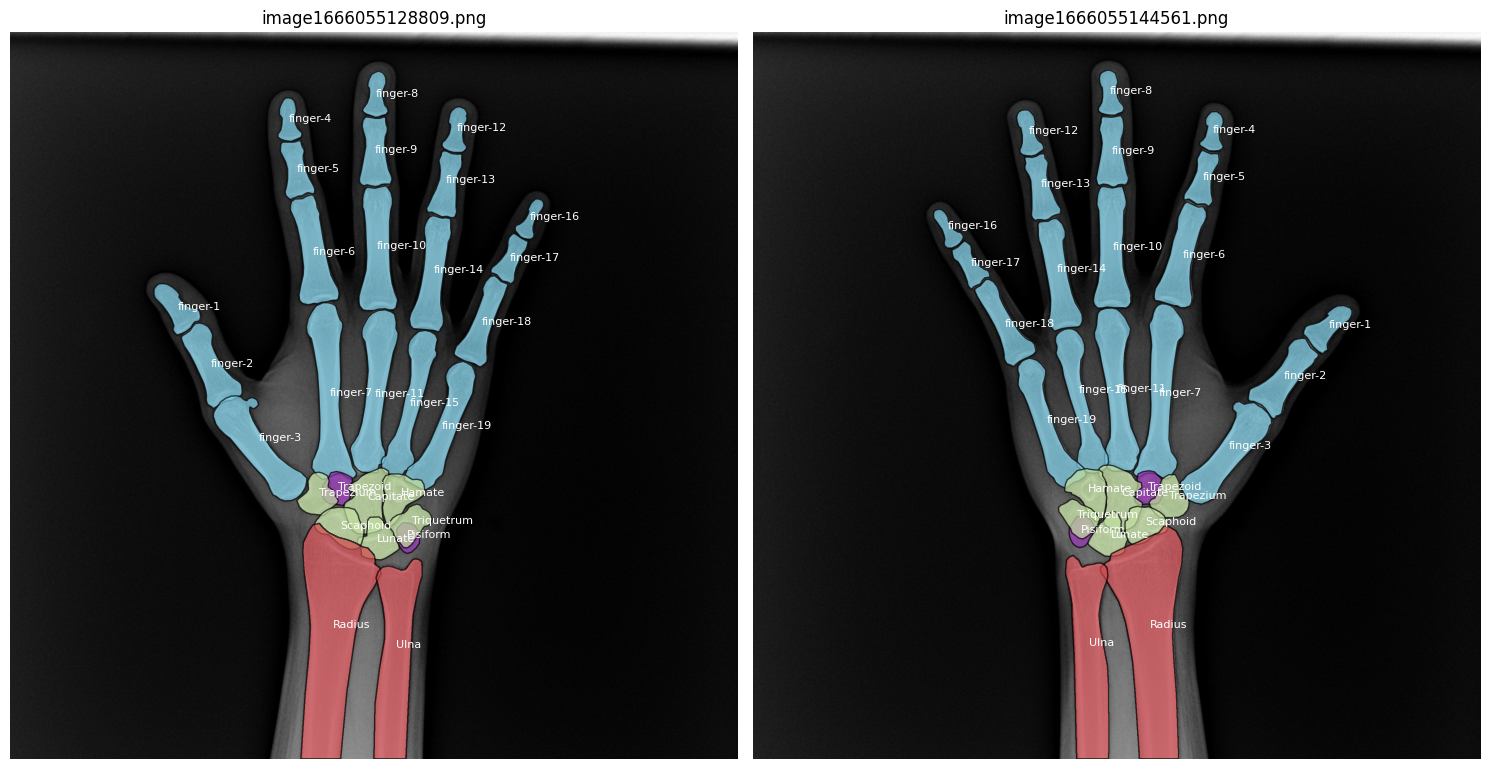

In [83]:
random_vis_with_plt('train')

In [84]:
def vis_with_plt(method: str, patient_id: str):
    base_path = '/data/ephemeral/home/data'
    img_root = os.path.join(base_path, method, 'DCM')
    annot_root = os.path.join(base_path, method, 'outputs_json')
    
    print(f"Image root path: {img_root}")
    print(f"Annotation root path: {annot_root}")
    
    # 특정 환자 디렉토리 선택
    patient_dir = os.path.join(img_root, patient_id)
    
    if not os.path.exists(patient_dir):
        raise ValueError(f"Patient directory not found: {patient_dir}")
        
    folder_name = os.path.basename(patient_dir)
    print(f"Selected patient directory: {patient_dir}")
    print(f"Folder name: {folder_name}")
    
    # 이미지 파일 찾기
    img_paths = glob(os.path.join(patient_dir, "*.png"))
    if not img_paths:
        img_paths = glob(os.path.join(patient_dir, "*.jpg")) or \
                   glob(os.path.join(patient_dir, "*.jpeg")) or \
                   glob(os.path.join(patient_dir, "*.dcm"))
    
    print(f"Found image paths: {img_paths}")
    
    # annotation 파일 찾기
    annot_paths = glob(os.path.join(annot_root, folder_name, "*.json"))
    print(f"Found annotation paths: {annot_paths}")
    
    if not img_paths or len(img_paths) < 2:
        raise ValueError(f"Expected 2 images, found {len(img_paths)} in {patient_dir}")
    
    if not annot_paths or len(annot_paths) < 2:
        raise ValueError(f"Expected 2 annotations, found {len(annot_paths)} in {annot_root}/{folder_name}")
    
    l_img_path, r_img_path = sorted(img_paths)[:2]
    l_annot_path, r_annot_path = sorted(annot_paths)[:2]
    
    l_img = Image.open(l_img_path).convert("RGB")
    r_img = Image.open(r_img_path).convert("RGB")
    l_json = json.load(open(l_annot_path))
    r_json = json.load(open(r_annot_path))
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 15))
    
    # 왼쪽 이미지 시각화
    axes[0].imshow(l_img)
    axes[0].set_title(os.path.basename(l_img_path))
    axes[0].axis('off')
    for annot in l_json['annotations']:
        points = [tuple(pts) for pts in annot['points']]
        orin_label = annot['label'] 
        label = orin_label
        if label.startswith('finger'):
            label = 'finger'
        elif label not in COLOR:
            label = 'wrist'
            
        poly = patches.Polygon(
            points, 
            closed=True, 
            facecolor=[ck/255 for ck in COLOR[label]], 
            edgecolor='black',
            alpha=0.7
        )
        axes[0].add_patch(poly)
        cx, cy = sum([p[0] for p in points]) / len(points), sum([p[1] for p in points]) / len(points)
        axes[0].text(cx, cy, orin_label, fontsize=8, color='white')

    # 오른쪽 이미지 시각화
    axes[1].imshow(r_img)
    axes[1].set_title(os.path.basename(r_img_path))
    axes[1].axis('off')
    for annot in r_json['annotations']:
        points = [tuple(pts) for pts in annot['points']]
        orin_label = annot['label'] 
        label = orin_label
        if label.startswith('finger'):
            label = 'finger'
        elif label not in COLOR:
            label = 'wrist'
            
        poly = patches.Polygon(
            points, 
            closed=True, 
            facecolor=[ck/255 for ck in COLOR[label]], 
            edgecolor='black',
            alpha=0.7
        )
        axes[1].add_patch(poly)
        cx, cy = sum([p[0] for p in points]) / len(points), sum([p[1] for p in points]) / len(points)
        axes[1].text(cx, cy, orin_label, fontsize=8, color='white')
        
    plt.tight_layout()
    plt.show()

Image root path: /data/ephemeral/home/data/train/DCM
Annotation root path: /data/ephemeral/home/data/train/outputs_json
Selected patient directory: /data/ephemeral/home/data/train/DCM/ID487
Folder name: ID487
Found image paths: ['/data/ephemeral/home/data/train/DCM/ID487/image1666661955150.png', '/data/ephemeral/home/data/train/DCM/ID487/image1666661971614.png']
Found annotation paths: ['/data/ephemeral/home/data/train/outputs_json/ID487/image1666661955150.json', '/data/ephemeral/home/data/train/outputs_json/ID487/image1666661971614.json']


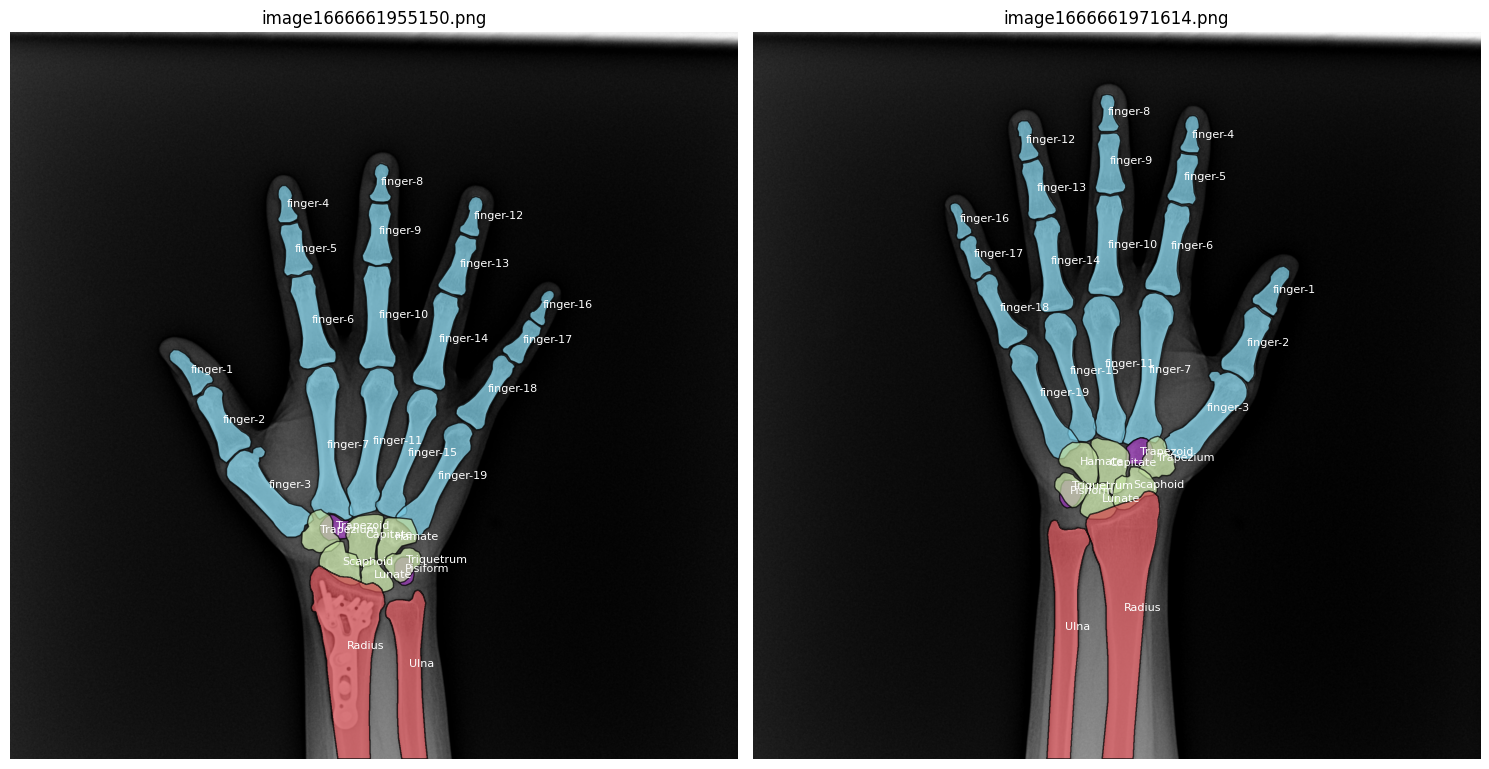

In [93]:

vis_with_plt('train', 'ID487')

## Test 시각화 하기

In [ ]:
from skimage import measure

# 결과 불러오기
res_df = pd.read_csv('output.csv')

# random으로 뽑기 위해 unique한 image_name을 뽑아냄 
uimg_names =  res_df['image_name'].unique().tolist()

# glob을 통해 img_path 전체를 받아오기
img_paths = glob(os.path.join("../data", "test", "*", "*", "*.png"))

In [ ]:

# random으로 뽑은 image_name에 해당하는 img_path를 뽑아내기
path_dict = dict()
for img_path in img_paths:
    img_name = img_path.split("/")[-1]
    path_dict[img_name] = img_path

In [ ]:
# random 추출
uimg_name = random.choice(uimg_names)

# 해당하는 img_path를 뽑아내기
img_path = path_dict[uimg_name]

# 해당하는 img의 결과값 뽑아내기
result = res_df[res_df['image_name'] == uimg_name]

In [ ]:
# rle를 decode하는 함수를 정의합니다.
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [ ]:
# 이미지를 불러옵니다.
img = Image.open(img_path).convert('RGB')
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(img)
axes[0].set_title('Original image')

axes[1].imshow(img)
axes[1].set_title('Image with pred mask')

for idx, res in enumerate(result.values):
    _, cls_name, rle = res
    # 디코딩을 진행합니다.
    # nan (못잡았을 때)이면 빈 마스크를 만듭니다.
    try:    
        decoded_rle = rle_decode(rle, (2048, 2048))*255
    except:
        decoded_rle = np.zeros((2048, 2048), dtype=np.uint8)*255
    
    # 클래스 이름 시각화를 위해 전처리를 진행합니다.
    origin_cls_name = cls_name
    if cls_name.startswith('finger'):
        cls_name = 'finger'
    elif cls_name not in COLOR:
        cls_name = 'wrist'
    
    # scikit-image 라이브러리를 활용하여 contour를 찾습니다.
    # scikit-image의 contour는 (y, x) 형태로 나오기 때문에, (x, y)로 변경해줍니다.
    contours = measure.find_contours(decoded_rle, 0.5)[0]
    contours = np.flip(contours, axis=1)
    
    # 찾은 contour를 시각화합니다.
    poly = patches.Polygon(
        contours, 
        closed=True, 
        facecolor=[ck/255 for ck in COLOR[cls_name]], 
        edgecolor='black', 
        linewidth=2,
        alpha=0.2
    )
    axes[1].add_patch(poly)
    
    # contour의 중심점을 찾아, 클래스 이름을 시각화합니다.
    cx, cy = sum([p[0] for p in contours]) / len(contours), sum([p[1] for p in contours]) / len(contours)
    axes[1].text(cx, cy, origin_cls_name, fontsize=8, color='white')
    
plt.tight_layout()
plt.show()    

## meta 데이터 분석하기

In [17]:
meta_data = "/data/ephemeral/home/code/meta_data.xlsx"
meta = pd.read_excel(meta_data)

In [24]:
# 1. 각 변수의 기본 통계량
print("=== 기본 통계량 ===")
stats = meta[["나이", "체중(몸무게)", "키(신장)"]].describe()
print(stats)

# 2. 성별에 따른 평균값
print("\n=== 성별 기준 평균값 ===")
gender_means = meta.groupby("성별")[["나이", "체중(몸무게)", "키(신장)"]].mean()
print(gender_means)

# 3. 결측치 확인
print("\n=== 결측치 개수 ===")
missing = meta[["나이", "성별", "체중(몸무게)", "키(신장)"]].isnull().sum()
print(missing)

# 4. BMI 계산 (추가적인 인사이트)
meta['BMI'] = meta['체중(몸무게)'] / ((meta['키(신장)']/100) ** 2)
print("\n=== BMI 통계량 ===")
print(meta.groupby("성별")['BMI'].describe())


=== 기본 통계량 ===
               나이     체중(몸무게)       키(신장)
count  550.000000  550.000000  550.000000
mean    31.865455   64.516364  167.767455
std     10.382489   12.782005    7.956421
min     19.000000   42.000000  150.000000
25%     25.000000   55.000000  161.000000
50%     29.000000   63.000000  168.000000
75%     36.000000   74.000000  174.000000
max     69.000000  118.000000  187.000000

=== 성별 기준 평균값 ===
                 나이    체중(몸무게)       키(신장)
성별                                        
 남        60.875000  66.750000  168.625000
 여        53.555556  53.966667  158.333333
_x0008_남  29.724280  73.675309  174.162140
_x0008_여  30.617100  56.394796  162.279554
남         47.727273  72.545455  174.045455
여         57.300000  59.300000  160.900000

=== 결측치 개수 ===
나이         0
성별         0
체중(몸무게)    0
키(신장)      0
dtype: int64

=== BMI 통계량 ===
          count       mean       std        min        25%        50%  \
성별                                                                      


In [23]:
# 5. 상관관계 분석
print("\n=== 변수간 상관관계 ===")
correlation = meta[["나이", "체중(몸무게)", "키(신장)"]].corr()
print(correlation)

# 6. 성별 분포
print("\n=== 성별 분포 ===")
gender_dist = meta["성별"].value_counts()
print(gender_dist)
print("\n성별 비율:")
print(meta["성별"].value_counts(normalize=True))

# 7. 나이대별 분포 (10살 단위로 구분)
meta['나이대'] = (meta['나이'] // 10) * 10
print("\n=== 나이대별 분포 ===")
age_dist = meta['나이대'].value_counts().sort_index()
print(age_dist)


=== 변수간 상관관계 ===
               나이   체중(몸무게)     키(신장)
나이       1.000000  0.026715 -0.119368
체중(몸무게)  0.026715  1.000000  0.693398
키(신장)   -0.119368  0.693398  1.000000

=== 성별 분포 ===
성별
_x0008_여    269
_x0008_남    243
남            11
여            10
 여            9
 남            8
Name: count, dtype: int64

성별 비율:
성별
_x0008_여    0.489091
_x0008_남    0.441818
남           0.020000
여           0.018182
 여          0.016364
 남          0.014545
Name: proportion, dtype: float64

=== 나이대별 분포 ===
나이대
10      3
20    294
30    159
40     52
50     23
60     19
Name: count, dtype: int64


/tmp/ipykernel_52849/1351567566.py:26: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_52849/1351567566.py:26: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


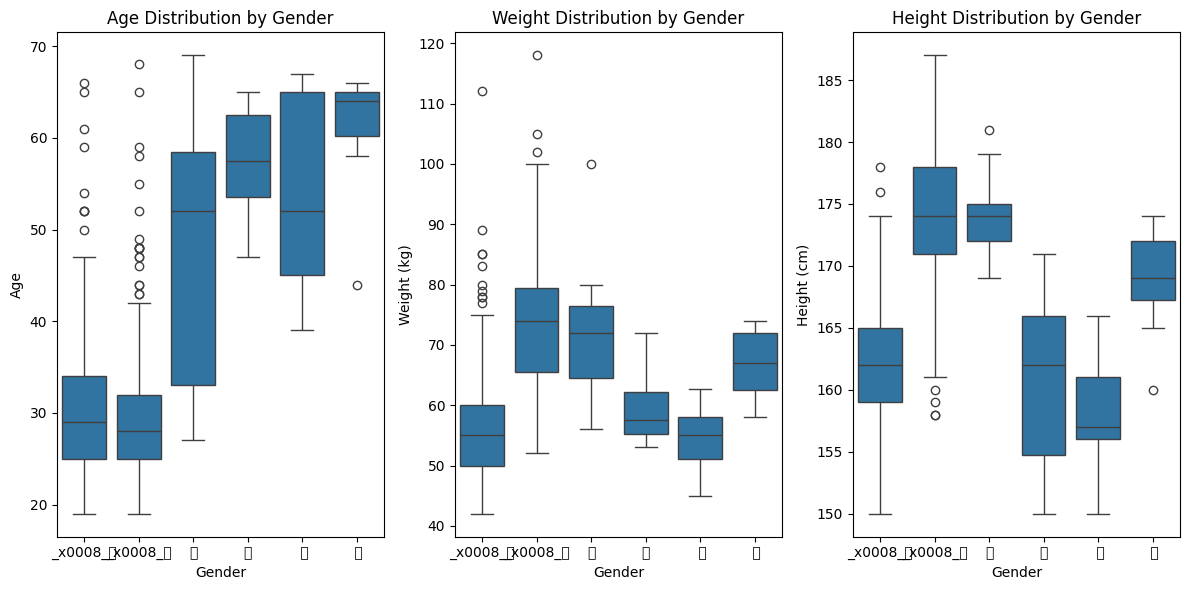

In [28]:
# Set figure size and create subplots
plt.figure(figsize=(12, 6))

# 1. Age distribution by gender
plt.subplot(1, 3, 1)
sns.boxplot(x="성별", y="나이", data=meta)
plt.title("Age Distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("Age")

# 2. Weight distribution by gender
plt.subplot(1, 3, 2)
sns.boxplot(x="성별", y="체중(몸무게)", data=meta)
plt.title("Weight Distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("Weight (kg)")

# 3. Height distribution by gender
plt.subplot(1, 3, 3)
sns.boxplot(x="성별", y="키(신장)", data=meta)
plt.title("Height Distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("Height (cm)")

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

In [30]:
meta["성별"] = ["male" if "남" in sex else "female" for sex in meta["성별"] ]

In [33]:
total_list=[]
for key in ["male", "female"]:
    data_list=[]
    for i in meta[meta["성별"]==key]["ID"]:
        path = "/data/ephemeral/home/data/train/outputs_json/ID"+str(i).zfill(3)
        try:
            for img in os.listdir(path):
                json_path = os.path.join(path, img)
                with open(json_path, "r") as f:
                    temp = json.load(f)
                    values=[]
                    for i in range(len(temp["annotations"])):
                        points = np.array(temp["annotations"][i]["points"])
                        values.append(PolyArea(points[:, 0], points[:, 1])) 
                    data_list.append(values)
        except Exception as e:
            pass
    total_list.append(data_list)

In [34]:
maledf = pd.DataFrame(total_list[0])
femaledf = pd.DataFrame(total_list[1])

male_info = maledf.describe()
female_info = femaledf.describe()

/tmp/ipykernel_52849/248279851.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


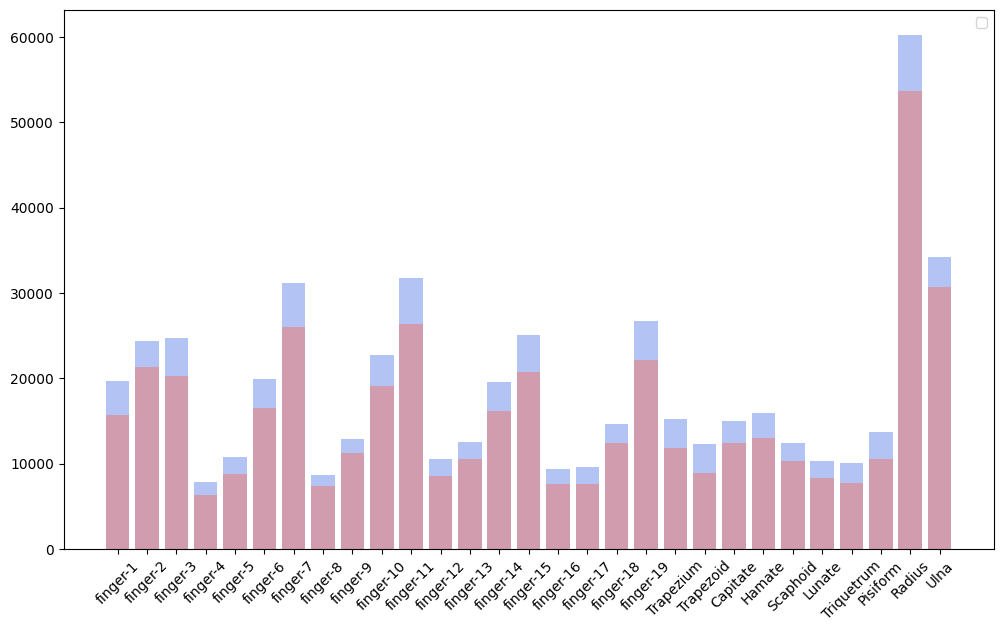

In [35]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.bar([CLASSES[i] for i in range(29)], male_info.loc["mean"], color="royalblue", alpha=0.4)
ax.bar([CLASSES[i] for i in range(29)], female_info.loc["mean"], color="tomato", alpha=0.4)

# ax.bar(male_info.columns, male_info.loc["mean"], width=width, label="male")
plt.xticks(rotation=45)
ax.legend()